## Target Distribution & class imbalance

## context 
class imbalance is the defining characteristic of fraud detection problems. with only approximately 3.5% fraudulent transaction, naive models will simply predict not fraud for everthing and achieve 96 % accuracy while being completly useless in practice

## objective 
- quantify the exact class imbalance ratio
- analyze how fraud distributes accros key features 
- explore temporal pattern in fraud occurrence
- establish strategies for training and evaluation under imbalance

In [1]:
# import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

train = pd.read_parquet('../data/interim/train_merged.parquet')
print(f'data loaded :{train.shape}')

data loaded :(590540, 434)


Target Distribution : 
Not fraud = 569,877 (96.50%)
Fraud : 569,877 (3.50%)
Imbalanced Ratio : 27:1


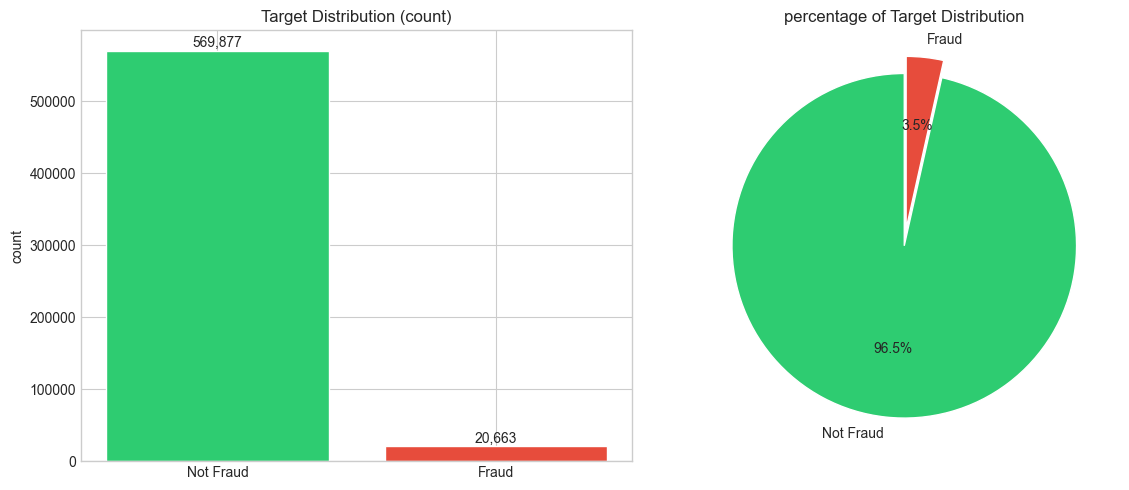

In [2]:
# target distribution
fraud_counts = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

print('Target Distribution : ')
print(f'Not fraud = {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)')
print(f'Fraud : {fraud_counts[0]:,} ({fraud_pct[1]:.2f}%)')
print(f'Imbalanced Ratio : {fraud_counts[0] // fraud_counts[1]}:1')

fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].bar(['Not Fraud', 'Fraud'],
            fraud_counts.values,
            color = ['#2ecc71', '#e74c3c'])
axes[0].set_title('Target Distribution (count)')
axes[0].set_ylabel('count')
for i,  v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center')

axes[1].pie(fraud_pct.values,
            labels=['Not Fraud', 'Fraud'],
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            startangle=90,
            explode=[0,0.1]
            )
axes[1].set_title('percentage of Target Distribution')
plt.tight_layout()
plt.show()

    

## Insight :  Understanding the imbalance

from the result we can quantify the challenge we are facing: 

- ~3.5 positive rate : approximately 20.663 fraud cases out of 590.540
- 27:1 imbalance ratio : this is a significant but managable with proper technique
- enough positive sample ( 20k ) : we have sufficient fraud case for robust model training 

this level of imbalance requires metric awarness but doesnt necessitate aggresive oversampling technique like smote, which often hurt generalization performance 

In [ ]:
## fraud by product code

product_fraud = train.groupby('ProductCD')['isFraud'].agg(['count','sum','mean'])
product_fraud.columns = ['Count', 'Fraud Count', 'Fraud Rate']
product_fraud['Fraut Rate'] = product_fraud['Fraud Rate'] * 100

print('Fraud Rate by Product Code :')
print(product_fraud.sort_values('Fraud Rate', ascending=False).to_string())

fig, ax = plt.subplots(figsize=(10,5))
product_fraud['Fraud Rate'].plot(kind='bar', color='coral', ax=ax)
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate By Product Code')
ax.axhline(y=train['isFraud'].mean()*100, color='red', linestyle='--', label='Overal')
plt.tight_layout()
plt.show()
